In [26]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


def flatten(array):
    array = np.nan_to_num(array, nan =0)
    max = np.max(array)
    min = np.min(array)
    flatten = (array-min)/(max-min)
    return flatten[::-1,:]
    
array_list_0 = np.array([flatten(eddies_train.eddies.values[i]) for i in range(40)])
array_list_1 = np.array([flatten(eddies_train.eddies.values[i]) for i in range(1,41)])
array_list_2 = np.array([flatten(eddies_train.eddies.values[i]) for i in range(2,42)])
array_list_3 = np.array([flatten(eddies_train.eddies.values[i]) for i in range(3,43)])

array_diff_1 = array_list_1-array_list_0
array_diff_2 = array_list_2-array_list_1
array_diff_3 = array_list_3-array_list_2
array_diff=np.where(((array_diff_1!=0) & (array_diff_2!=0))|((array_diff_2!=0) & (array_diff_3!=0))|((array_diff_1!=0)&(array_diff_3!=0)&(array_diff_2==1)),0,1)

array_list = array_list_1*array_diff





print(array_list.shape)
print(array_list[0].shape)
height, width = array_list[0].shape
fig, ax = plt.subplots(figsize=(10,8)) 
def init():
    ax.imshow(array_list[0])
    return [ax]

def update(frame):
    ax.imshow(array_list[frame])
    return [ax]


animation = FuncAnimation(fig, update, frames=len(array_list), init_func=init)

output_video = 'height_video_2.mp4'

animation.save(output_video, fps=2, extra_args=['-vcodec', 'libx264'])


NameError: name 'eddies_train' is not defined

### This is where I build my dataset. It will be splitted after on the train cell

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
import xarray as xr
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
import netCDF4
import h5netcdf
from datetime import datetime
import torch
from torchvision import transforms
from torch.utils.data import TensorDataset
from torch.utils.data import random_split
from utils.util import addGitignore
import os


class GenerateDataset():
    def __init__(self):
        self.OSSE_test  = None
        self.OSSE_train = None
        self.eddies_train = None
        self.following_dates = []
        self.generate()


    def generate(self):
        files = []
        for dirname, _, filenames in os.walk('./data/'):
            for filename in filenames:
                print(os.path.join(dirname, filename))
                files.append(os.path.join(dirname, filename))
        self.eddies_train = xr.open_dataset(files[1])
        self.OSSE_test = xr.open_dataset(files[0])
        self.OSSE_train = xr.open_dataset(files[2])
        self.OSSE_train = self.OSSE_train.rename({"time_counter":"time"})
       

        path = 'dataset'
        addGitignore(path)
    
        if not os.path.exists(path):
            os.makedirs(path)
        else:
            pass
        pass
    def followingDates(self,num_date,type='Train'):
        if (type =='Train'):
            print('train')
            dates_list = [datetime.strptime(str(self.OSSE_train.time[i].values)[:10], '%Y-%m-%d') for i in range(len(self.OSSE_train.time))]
            followingDatesIndex = np.where([all((dates_list[j+i+1] - dates_list[j+i]).days==1 for i in range(num_date)) for j in range(len(dates_list) - 2*num_date)])[0]

        if (type =='Test'):
            followingDatesIndex=[0,10,20,30]

        return followingDatesIndex
    
    def generateAndSplitDataset(self,X,y, validation_fraction=0.2,running_instance = 'Train_2'):

        path = 'DATASET_'+running_instance
        addGitignore(path)

     
        if not os.path.exists(path):
            os.makedirs(path)
        else:
            pass
        pass
    
        dataset = TensorDataset(X, y)
        validation_fraction = 0.2
        val_size = int(validation_fraction * len(dataset))
        train_size = len(dataset) - val_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        torch.save(train_dataset,f'{path}/TrainDataset_{running_instance}__dataset.pt')
        torch.save(val_dataset,f'{path}/ValDataset{running_instance}__dataset.pt')
        return train_dataset,val_dataset
    

    def generateAndSplitDatasetGeneral():
        pass
    
    def preprocessingData(self,num_date,type ='Train',running_instance = 'Train_2'):
        followingDatesIndex= self.followingDates(num_date,type=type)
        if type =='Train':
            X_dataset_train= torch.tensor(np.array([[self.OSSE_train.sossheig.values[i+j]for i in range(num_date)] for j in followingDatesIndex]))
            y_dataset_train = torch.tensor(np.array([[self.eddies_train.eddies.values[i+j]for i in range(num_date,2*num_date)]for j in followingDatesIndex]))
            trans = transforms.Resize((96*4,192*4))
            nan_mask_label_deconv = torch.isnan(y_dataset_train)
            X_dataset_train=trans(X_dataset_train)
            y_dataset_train=trans(y_dataset_train)
            #Separation of eddies results on 3 layers

            condition_0 = (y_dataset_train<=0.5)
            condition_1 = (y_dataset_train>0.5)&(y_dataset_train<1.5)
            condition_2 = (y_dataset_train>=1.5)
            y_dataset_train= torch.cat([torch.where(condition_0,torch.tensor(1),torch.tensor(0)),
                             torch.where(condition_1,torch.tensor(1),torch.tensor(0)),torch.where(condition_2,torch.tensor(1),torch.tensor(0))],dim=1)
            nan_mask_label = torch.isnan(y_dataset_train)
            y_dataset_train = torch.where(nan_mask_label, torch.tensor(0), y_dataset_train)
            nan_mask = torch.isnan(X_dataset_train)
            X_dataset_train = torch.where(nan_mask, torch.tensor(0.0), X_dataset_train)
            print("*"*100)
            print(f"Dataset has been initialised, inputs shape {X_dataset_train.shape}, {len(X_dataset_train)} elements of depth {len(X_dataset_train[0])}.")
            print("Use generateAndSplit to generate and save TRAIN and VAL")
            print(f"Target shape is a tensor of depth {len(y_dataset_train[0])}")
            print("*"*100)

            
            return X_dataset_train, y_dataset_train,nan_mask_label_deconv, nan_mask_label
        
        if type == 'Test':
            print('test')
            X_dataset_test = torch.tensor(np.array([[self.OSSE_test.sossheig.values[i+j]for i in range(num_date)] for j in followingDatesIndex]))
            
            return X_dataset_test
        
    


In [48]:
test = GenerateDataset()
test.preprocessingData(1)
print()

./data/OSSE_U_V_SLA_SST_2015_TEST_for_FORECAST.nc
./data/eddies_TRAIN_for_FORECAST.nc
./data/OSSE_U_V_SLA_SST_2015_TRAIN_for_FORECAST.nc
train
****************************************************************************************************
Dataset has been initialised, inputs shape torch.Size([235, 1, 384, 768]), 235 elements of depth 1.
Use generateAndSplit to generate and save TRAIN and VAL
Target shape is a tensor of depth 3
****************************************************************************************************



In [ ]:

X=test.nameToBeDefined(10,type='Test')
X

torch.Size([4, 10, 357, 717])

In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
files = []
import os
for dirname, _, filenames in os.walk('./data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        files.append(os.path.join(dirname, filename))
        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


import xarray as xr
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
import netCDF4
import h5netcdf




import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
files = []
import os
for dirname, _, filenames in os.walk('./data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        files.append(os.path.join(dirname, filename))


eddies_train = xr.open_dataset(files[1])
OSSE_test = xr.open_dataset(files[0])
OSSE_train = xr.open_dataset(files[2])
OSSE_train = OSSE_train.rename({"time_counter":"time"})




from datetime import datetime
import torch
from torchvision import transforms
trans = transforms.Resize((96*4,192*4))


dates_list = [datetime.strptime(str(OSSE_train.time[i].values)[:10], '%Y-%m-%d') for i in range(len(OSSE_train.time))]
dates_se_following = np.where([all((dates_list[j+i+1] - dates_list[j+i]).days==1 for i in range(20)) for j in range(len(dates_list) - 20 )])[0]


X_dataset_train= torch.tensor(np.array([[OSSE_train.sossheig.values[i+j]for i in range(10)] for j in dates_se_following]))
y=[]
"""
for j in dates_se_following:
    array_list_0 = np.array([(eddies_train.eddies.values[i]) for i in range(j,j+18)])
    array_list_1 = np.array([(eddies_train.eddies.values[i]) for i in range(j+1,j+19)])
    array_list_2 = np.array([(eddies_train.eddies.values[i]) for i in range(j+2,j+20)])
    array_diff_1 = array_list_1-array_list_0
    array_diff_2 = array_list_2-array_list_1

    array_diff=np.where((array_diff_1!=0) & (array_diff_2!=0),0,1)
    array_list = array_list_1*array_diff
    y.append(array_list)
    """
y =np.array(y)
print(y.shape)
print(len(dates_se_following))
#y_dataset_train = torch.tensor(np.array([[y[j][i]for i in range(11,17)]for j in range(len(dates_se_following))]))
y_dataset_train = torch.tensor(np.array([[eddies_train.eddies.values[i+j]for i in range(10,20)]for j in dates_se_following]))

nan_mask_label_deconv = torch.isnan(y_dataset_train)


y_dataset_train = trans(y_dataset_train)

condition_0 = (y_dataset_train<=0.5)
condition_1 = (y_dataset_train>0.5)&(y_dataset_train<1.5)
condition_2 = (y_dataset_train>=1.5)
y_dataset_train= torch.cat([torch.where(condition_0,torch.tensor(1),torch.tensor(0)),
                             torch.where(condition_1,torch.tensor(1),torch.tensor(0)),torch.where(condition_2,torch.tensor(1),torch.tensor(0))],dim=1)
print(torch.sum(y_dataset_train))
nan_mask_label = torch.isnan(y_dataset_train)

y_dataset_train = torch.where(nan_mask_label, torch.tensor(0), y_dataset_train)

    
X_dataset_train =trans(X_dataset_train)
nan_mask = torch.isnan(X_dataset_train)

#passage des NaN en 0. pour hauteur de mer
X_dataset_train = torch.where(nan_mask, torch.tensor(0.0), X_dataset_train)



del X_dataset_train
del y_dataset_train

./data/OSSE_U_V_SLA_SST_2015_TEST_for_FORECAST.nc
./data/eddies_TRAIN_for_FORECAST.nc
./data/OSSE_U_V_SLA_SST_2015_TRAIN_for_FORECAST.nc
(0,)
156
tensor(307374600)


This cell below is useful to create the mask for the back_resize to the original shape of pictures

### If you want to use Weitghted MSE for loss
You shall check the lenght of the array, should be 10.zero_class concat 10.one_class concat 10.two_class



### Train parameters and calling
You should load Uned before and check the commented lines, you can start from  or download a pretrained net.

In [6]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from CNN.unet import UNet

from utils.device import self_device
device = self_device()


model_list=[]
num_epochs =100
learning_rate=0.01
batch_size = 3




model = UNet(n_class=3,verbose=False)


weights_path = 'UNet_trained/UNet_Train_1_Epoch_61_valacc_90.10619354248047.pth'


model.load_state_dict(torch.load(weights_path))
model.to(device)
optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.99))
scheduler =  lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.98)
criterion = nn.MSELoss()
#dataset = TensorDataset(X_dataset_train, y_dataset_train)
#torch.save(dataset,f'dataset/{running_instance}__dataset.pt')
#validation_fraction = 0.2
#val_size = int(validation_fraction * len(dataset))
#train_size = len(dataset) - val_size
#train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_dataset = torch.load('dataset/Train_1_Train_dataset.pt')
val_dataset = torch.load('dataset/Train_1_val_dataset.pt')
TD = TrainDataset(model,criterion,  optimizer,scheduler,num_epochs,learning_rate,batch_size,device,nan_mask_label[:batch_size,:,:,:],running_instance=running_instance)


model = TD.train_model(train_dataset,val_dataset)

****************************************************************************************************
****************************************************************************************************
----------------------------------------------------------------------------------------------------
Epoch 64/100
----------------------------------------------------------------------------------------------------
batch_loss 1_Epoch_64=0.06, accuracy = 91.87%
batch_loss 10_Epoch_64=0.07, accuracy = 89.30%
batch_loss 20_Epoch_64=0.07, accuracy = 90.43%
batch_loss 30_Epoch_64=0.07, accuracy = 91.31%
batch_loss 40_Epoch_64=0.07, accuracy = 91.31%
EPOCH ACCURACY = 90.85 %
****************************************************************************************************
train Loss: 0.0640 Acc: 90.8452
****************************************************************************************************
batch_loss 1_Epoch_64=0.07, accuracy = 89.97%
batch_loss 2_Epoch_64=0.07, accuracy = 90.25

In [8]:
torch.save(train_dataset,f'dataset/{running_instance}_Train_dataset.pt')
torch.save(val_dataset,f'dataset/{running_instance}_val_dataset.pt')

In [3]:

import torch
from torch.utils.data import DataLoader
import time
import copy

 
"""
 This is my train method, classic. 
 Once will remarks that there are no test in this method, accordingly to the scope of our 
 subject. 
 
"""    
class TrainDataset:
    def __init__(self,model,criterion,
                 optimizer,scheduler,num_epochs,learning_rate,batch_size,device,nan_mask_label,running_instance):
        self.device = device
        self.model = model
        self.criterion=criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.num_epochs=num_epochs
        self.batch_size=batch_size
        self.learning_rate =learning_rate
        self.nan_mask_label = nan_mask_label
        self.running_instance = running_instance





    def train_model(self,train_dataset,val_dataset):
      
        val_acc = []
        val_loss = []
        train_acc = []
        train_loss = []
        epoch=40

        train_loader  = DataLoader(dataset = train_dataset, batch_size=self.batch_size, shuffle =True,drop_last=True)
        val_loader = DataLoader(dataset = val_dataset, batch_size=self.batch_size,shuffle=True, drop_last=True)

        dataloaders = {'train': train_loader, 'val': val_loader}
        start = time.time()
        best_model_wts = copy.deepcopy(self.model.state_dict())
        best_acc = 0
        list = {'train': {'acc': train_acc, 'loss': train_loss}, 
            'val':{'acc': val_acc, 'loss': val_loss}}
       

        
        for epoch in range(64,self.num_epochs):
            print('-' * 100)
            print('Epoch {}/{}'.format(epoch, self.num_epochs))
            print('-' * 100)
            for phase in ['train','val']:
                if phase =='train':
                    self.model.train()
                else:
                    self.model.eval()
                running_corrects = 0.0
                batch_number = 0
                batch_acc_single_element = 0
                for inputs, labels in dataloaders[phase]:
                    batch_number+=1

                    if self.device == 'mps':
                        print('voila')
                        inputs = inputs.to(self.device).float()
                        labels = labels.to(self.device).float()
                    else :
                        inputs = inputs.float().to(self.device)
                        labels = labels.float().to(self.device)
                        

                    self.optimizer.zero_grad()
                 
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        loss = self.criterion(outputs[~self.nan_mask_label],labels[~self.nan_mask_label])
                
                        if phase == 'train':
                            loss.backward()
                            self.optimizer.step()
                        if (batch_number%10==0 )|(phase == 'val')|(batch_number ==1):
                            batch_acc_single_element +=1
                            reshaped_output = outputs.view(outputs.size(0), 3, 10, outputs.size(2), outputs.size(3))
                                    
                            max_indices = torch.argmax(reshaped_output, dim=1)
                            one_hot_encoding = torch.zeros_like(reshaped_output)
                            preds = one_hot_encoding.scatter_(1, max_indices.unsqueeze(1), 1)
                            preds = preds.view_as(outputs)
                            batch_accuracy =torch.sum(torch.where((labels==preds)&(labels>0.5),torch.tensor(1).to(self.device),torch.tensor(0).to(self.device))[~self.nan_mask_label])
                            batch_card = torch.sum(labels[~self.nan_mask_label])
                            accuracy = batch_accuracy*100/(batch_card)
                            print(f"batch_loss {batch_number}_Epoch_{epoch}={loss.item():.2f}, accuracy = {accuracy:.2f}%")
                            running_corrects +=batch_accuracy
                epoch_acc =100*running_corrects/(batch_acc_single_element*batch_card)
                print(f"EPOCH ACCURACY = {epoch_acc:.2f} %")
                        
                            
                
                    
                #epoch_loss = running_loss / dataset_sizes[phase]

                #if self.device =='mps':
                    #epoch_acc = running_corrects.float() / dataset_sizes[phase]
                #else :
                    #epoch_acc = running_corrects.float()/ dataset_sizes[phase]
                list[phase]['loss'].append(loss)
                list[phase]['acc'].append(epoch_acc)
                print("*"*100)
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, loss.item(), epoch_acc))
                print("*"*100)
        
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    torch.save(model.state_dict(), f'UNet_trained/UNet_{self.running_instance}_Epoch_{epoch}_valacc_{epoch_acc}.pth')
            
            print()
            
        time_elapsed = time.time() - start
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))
        
        # load best model weights
        self.model.load_state_dict(best_model_wts)
        
            
        return self.model









In [ ]:

import torchvision
from torchviz import make_dot
import torch
#from CNN.SimpleCNN import SimpleModel


model = UNet(10)


input_tensor = torch.randn((1,10, 96*4, 192*4))


output = model(input_tensor)
graph = make_dot(output, params=dict(model.named_parameters()))


graph.render('model_graph')


graph.view()

'model_graph.pdf'

In [ ]:
print(len(model_list))

6


In [67]:
array_list_following = []
model.to('cpu')
model.eval()

for i in range(10):
    




    item= X_dataset_train[i].unsqueeze(0)
    label = y_dataset_train[i]
    item =model(item)
    reshaped_output = item.view(item.size(0), 3, 6, item.size(2), item.size(3))
    max_indices = torch.argmax(reshaped_output, dim=1)
    one_hot_encoding = torch.zeros_like(reshaped_output)
    item = one_hot_encoding.scatter_(1, max_indices.unsqueeze(1), 1)
    print('one_hot_encoding.shape',one_hot_encoding.shape)

    item =0*item[:,0,:,:,:]+1*item[:,1,:,:,:]+2*item[:,2,:,:,:]
    print("item.shape",item.shape)
    


    print("label.shape",label.shape)
    print(item.shape)
    

    #item = trans(torch.from_numpy(item[:,:,:]))
   
    #item = item.squeeze(0)
    #print(item.shape)


    #item = torch.where(item>torch.tensor(0.2),torch.tensor(1),torch.tensor(0))
    #item_0 = torch.where(item[0,0 ,:,:]>torch.tensor(0.5),torch.tensor(1),torch.tensor(0))
    #item_1 = torch.where(item[0,1 ,:,:]>torch.tensor(0.2),torch.tensor(1),torch.tensor(0))
    #item_2 = torch.where(item[0,2 ,:,:]>torch.tensor(0.2),torch.tensor(1),torch.tensor(0))
    #item_final = 0*item_0+1*item_1+2*item_2
    #print(item_final.shape)
    item=item.squeeze(0)
    print(item.shape)
    item_final = item[:,:,:].detach().numpy()
    print(item_final.shape)
    array_list_following.append(item_final)

one_hot_encoding.shape torch.Size([1, 3, 6, 384, 768])
item.shape torch.Size([1, 6, 384, 768])
label.shape torch.Size([18, 384, 768])
torch.Size([1, 6, 384, 768])
torch.Size([6, 384, 768])
(6, 384, 768)
one_hot_encoding.shape torch.Size([1, 3, 6, 384, 768])
item.shape torch.Size([1, 6, 384, 768])
label.shape torch.Size([18, 384, 768])
torch.Size([1, 6, 384, 768])
torch.Size([6, 384, 768])
(6, 384, 768)
one_hot_encoding.shape torch.Size([1, 3, 6, 384, 768])
item.shape torch.Size([1, 6, 384, 768])
label.shape torch.Size([18, 384, 768])
torch.Size([1, 6, 384, 768])
torch.Size([6, 384, 768])
(6, 384, 768)
one_hot_encoding.shape torch.Size([1, 3, 6, 384, 768])
item.shape torch.Size([1, 6, 384, 768])
label.shape torch.Size([18, 384, 768])
torch.Size([1, 6, 384, 768])
torch.Size([6, 384, 768])
(6, 384, 768)
one_hot_encoding.shape torch.Size([1, 3, 6, 384, 768])
item.shape torch.Size([1, 6, 384, 768])
label.shape torch.Size([18, 384, 768])
torch.Size([1, 6, 384, 768])
torch.Size([6, 384, 768])

In [89]:
nan_mask_label = nan_mask_test[:1,:6,:,:]
trans_back = transforms.Resize((357,717))
nan_mask_label=trans_back(nan_mask_label)
print(nan_mask_label.shape)

torch.Size([1, 6, 357, 717])


In [105]:
array_list_following = []
model.to('cpu')
model.eval()

for i in range(4):
    




    item= X_dataset_test[i].unsqueeze(0)
  
    item =model(item)
    trans_back = transforms.Resize((357,717))
    item = trans_back(item)
    
    reshaped_output = item.view(item.size(0), 3, 6, item.size(2), item.size(3))
    max_indices = torch.argmax(reshaped_output, dim=1)
    one_hot_encoding = torch.zeros_like(reshaped_output)
    item = one_hot_encoding.scatter_(1, max_indices.unsqueeze(1), 1)

    print('one_hot_encoding.shape',one_hot_encoding.shape)

    item =0*item[:,0,:,:,:]+1*item[:,1,:,:,:]+2*item[:,2,:,:,:]
    print("item.shape",item.shape)
    item = torch.where(nan_mask_label,torch.tensor(999),item)


    print("label.shape",label.shape)
    print(item.shape)
    

    #item = trans(torch.from_numpy(item[:,:,:]))
   
    #item = item.squeeze(0)
    #print(item.shape)


    #item = torch.where(item>torch.tensor(0.2),torch.tensor(1),torch.tensor(0))
    #item_0 = torch.where(item[0,0 ,:,:]>torch.tensor(0.5),torch.tensor(1),torch.tensor(0))
    #item_1 = torch.where(item[0,1 ,:,:]>torch.tensor(0.2),torch.tensor(1),torch.tensor(0))
    #item_2 = torch.where(item[0,2 ,:,:]>torch.tensor(0.2),torch.tensor(1),torch.tensor(0))
    #item_final = 0*item_0+1*item_1+2*item_2
    #print(item_final.shape)
    item=item.squeeze(0)
    print(item.shape)
    item_final = item[:,:,:].detach().numpy()
    print(item_final.shape)
    array_list_following.append(item_final)

one_hot_encoding.shape torch.Size([1, 3, 6, 357, 717])
item.shape torch.Size([1, 6, 357, 717])
label.shape torch.Size([18, 384, 768])
torch.Size([1, 6, 357, 717])
torch.Size([6, 357, 717])
(6, 357, 717)
one_hot_encoding.shape torch.Size([1, 3, 6, 357, 717])
item.shape torch.Size([1, 6, 357, 717])
label.shape torch.Size([18, 384, 768])
torch.Size([1, 6, 357, 717])
torch.Size([6, 357, 717])
(6, 357, 717)
one_hot_encoding.shape torch.Size([1, 3, 6, 357, 717])
item.shape torch.Size([1, 6, 357, 717])
label.shape torch.Size([18, 384, 768])
torch.Size([1, 6, 357, 717])
torch.Size([6, 357, 717])
(6, 357, 717)
one_hot_encoding.shape torch.Size([1, 3, 6, 357, 717])
item.shape torch.Size([1, 6, 357, 717])
label.shape torch.Size([18, 384, 768])
torch.Size([1, 6, 357, 717])
torch.Size([6, 357, 717])
(6, 357, 717)


In [72]:
print(np.array(array_list_following).shape
      )

(4, 6, 357, 717)


In [91]:
import csv
output_file = 'predictioncomplete_999.csv'
with open(output_file, 'w', newline='') as csvfile:
    fieldnames = ['Id', 'Predicted']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for d in range(10):
        for m in range(4):
            data = array_list_following[m][d]
            for y, row in enumerate(data):
                for x, value in enumerate(row):
                    day=m*7+d
                    id = f"{day}_{y}_{x}"
                    value = np.int32(value)
                    writer.writerow({'Id': id, 'Predicted': value})
 

In [4]:

from torch.utils.data import DataLoader
val_dataset = torch.load('dataset/Train_1_val_dataset.pt')

val_loader = DataLoader(dataset = val_dataset, batch_size=len(val_dataset),shuffle=False, drop_last=False)
for input, labels in val_loader:
    break


In [10]:
print(input.shape)

torch.Size([31, 10, 384, 768])


In [8]:
from torchvision import transforms
array_list_following_train = []
array_list_ground_truth=[]
model = UNet(n_class=3)
weights_path = 'UNet_trained/UNet_Train_1_Epoch_98_valacc_91.76040649414062.pth'
model.load_state_dict(torch.load(weights_path))
model.to('cpu')
model.eval()

for i in range(len(input)):    
    item= input[i].unsqueeze(0)
    label = labels[i].unsqueeze(0)
    item =model(item)
    trans_back = transforms.Resize((357,717))
    item = trans_back(item)
    label = trans_back(label)
    print("item.shape",item.shape)
    print("label.shape",label.shape)
    reshaped_output = item.view(item.size(0), 3, 10, item.size(2), item.size(3))
    max_indices = torch.argmax(reshaped_output, dim=1)
    one_hot_encoding = torch.zeros_like(reshaped_output)
    item = one_hot_encoding.scatter_(1, max_indices.unsqueeze(1), 1)

    print('one_hot_encoding.shape',one_hot_encoding.shape)

    item =0*item[:,0,:,:,:]+1*item[:,1,:,:,:]+2*item[:,2,:,:,:]
    print("item.shape",item.shape)
    item = torch.where(nan_mask_label_deconv[0,:,:,:],torch.tensor(999),item)

    print(item.shape)
    print("label.shape",label.shape)

    reshaped_label = label.view(label.size(0), 3, 10, label.size(2), label.size(3))
    max_indices_label = torch.argmax(reshaped_label, dim=1)
    one_hot_encoding_label = torch.zeros_like(reshaped_label)
    label= one_hot_encoding_label.scatter_(1, max_indices_label.unsqueeze(1), 1)

    print('one_hot_encoding.shape',one_hot_encoding_label.shape)

    label=0*label[:,0,:,:,:]+1*label[:,1,:,:,:]+2*label[:,2,:,:,:]
    print("item.shape",label.shape)
    label = torch.where(nan_mask_label_deconv[0,:,:,:],torch.tensor(999),label)
    label=label.squeeze(0)
    print(label.shape)
    label_final = label[:,:,:].detach().numpy()
    print(label_final.shape)
    array_list_ground_truth.append(label_final)

    item=item.squeeze(0)
    print(item.shape)
    item_final = item[:,:,:].detach().numpy()
    print(item_final.shape)
    array_list_following_train.append(item_final)

item.shape torch.Size([1, 30, 357, 717])
label.shape torch.Size([1, 30, 357, 717])
one_hot_encoding.shape torch.Size([1, 3, 10, 357, 717])
item.shape torch.Size([1, 10, 357, 717])
torch.Size([1, 10, 357, 717])
label.shape torch.Size([1, 30, 357, 717])
one_hot_encoding.shape torch.Size([1, 3, 10, 357, 717])
item.shape torch.Size([1, 10, 357, 717])
torch.Size([10, 357, 717])
(10, 357, 717)
torch.Size([10, 357, 717])
(10, 357, 717)
item.shape torch.Size([1, 30, 357, 717])
label.shape torch.Size([1, 30, 357, 717])
one_hot_encoding.shape torch.Size([1, 3, 10, 357, 717])
item.shape torch.Size([1, 10, 357, 717])
torch.Size([1, 10, 357, 717])
label.shape torch.Size([1, 30, 357, 717])
one_hot_encoding.shape torch.Size([1, 3, 10, 357, 717])
item.shape torch.Size([1, 10, 357, 717])
torch.Size([10, 357, 717])
(10, 357, 717)
torch.Size([10, 357, 717])
(10, 357, 717)
item.shape torch.Size([1, 30, 357, 717])
label.shape torch.Size([1, 30, 357, 717])
one_hot_encoding.shape torch.Size([1, 3, 10, 357, 7

### Eddies animation 

<div class ='alert alert-success'>
The two next following cells are for creating video animation of prediction vs ground Truth
</div>

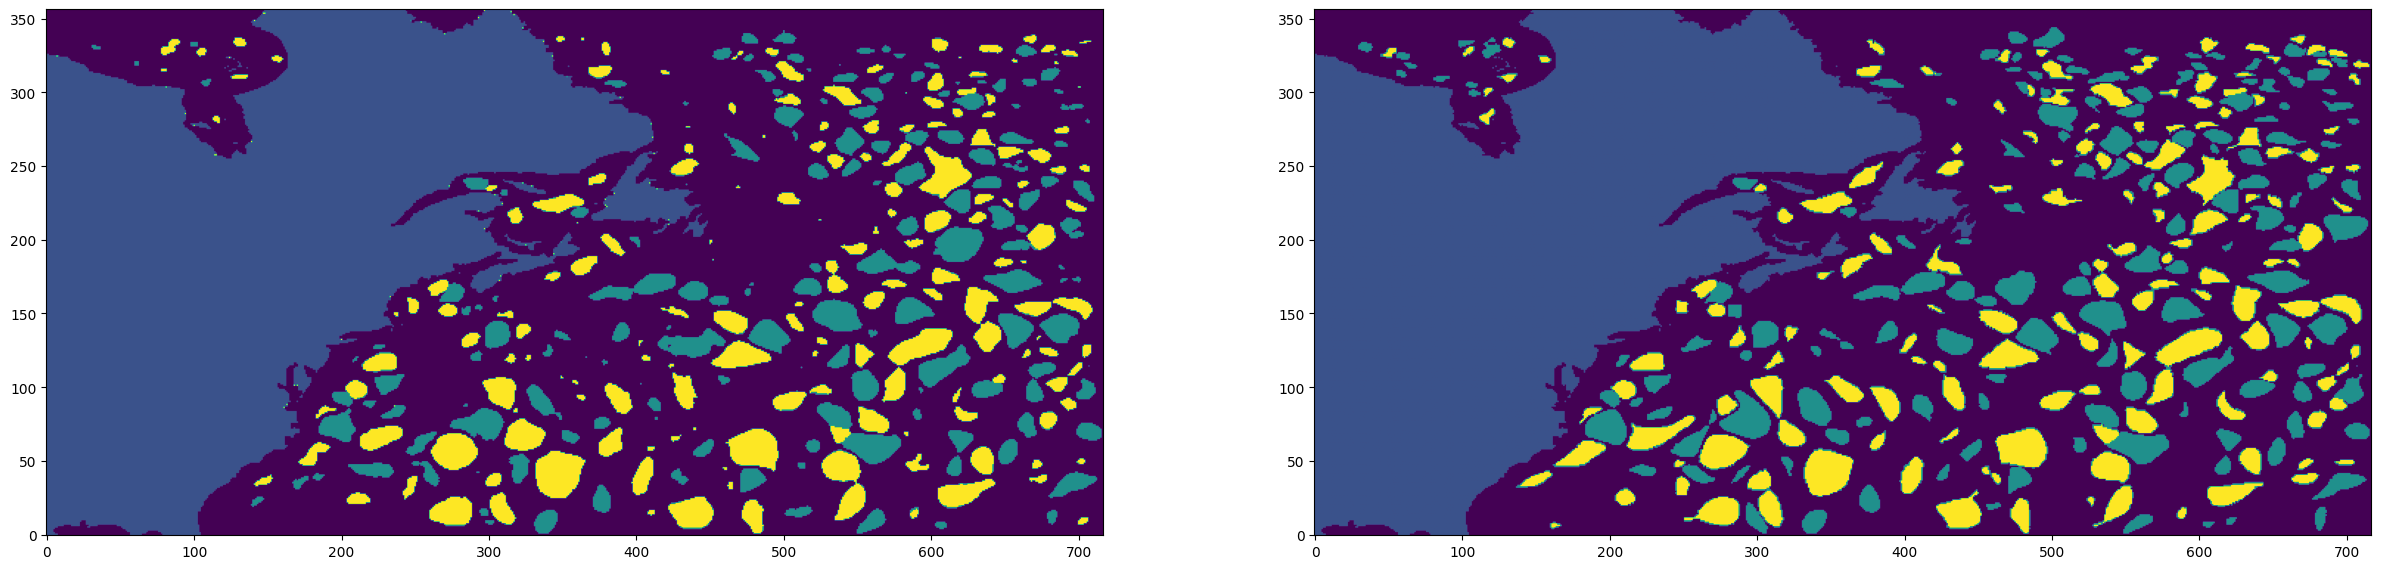

In [9]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


array_list_following_train=np.array(array_list_following_train)
array_list_following_pict_PDT=np.where(array_list_following_train>=100,0.5,array_list_following_train)


array_list_following_ground_truth=np.array(array_list_ground_truth)
array_list_following_pict_GT=np.where(array_list_following_ground_truth>=100,0.5,array_list_following_ground_truth)
fig, ax = plt.subplots(1, 2, figsize = (30, 24))
def init():
   
    ax[0].imshow(array_list_following_pict_PDT[10][0],origin="lower")
    #ax[0].title('Prediction eddies J+1')
    #ax[0].colorbar()
    ax[1].imshow(array_list_following_pict_GT[10][0],origin="lower")
    #ax[1].title(f'Ground Truth eddies J+1')
    #ax[1].colorbar()
    return [ax]

def update(frame):
    ax[0].imshow(array_list_following_pict_PDT[10][frame],origin="lower")
    #ax[0].title(f'Prediction eddies J+{1+frame}')
    #ax[0].colorbar()
    ax[1].imshow(array_list_following_pict_GT[10][frame],origin="lower")
    #ax[1].title(f'Prediction eddies J+{1+frame}')
    #ax[1].colorbar()
    return [ax]


animation = FuncAnimation(fig, update, frames=len(array_list_following_pict_PDT[1]), init_func=init)

output_video = 'predicted_video_eddies_train_predict.mp4'

animation.save(output_video, fps=1, extra_args=['-vcodec', 'libx264'])

### Attention ne pas supprimer cette cellule :

### TODO 
Confusion matrix






In [11]:
from sklearn.metrics import confusion_matrix

def confusion_matrix_(gT_label, pred_label):

    
    gT_label = np.array(gT_label).flatten()
    pred_label = np.array(pred_label).flatten()
    """
    card_zero = np.sum(np.where(gT_label==0),1,0)
    card_one = np.sum(np.where(gT_label ==1),1,0)
    card_two = np.sum(np.where(gT_label==2),1,0)

    card_false_0 = np.sum(np.where((gT_label!=0)&(pred_label==0),1,0))
    card_false_1 = np.sum(np.where((gT_label!=1)&(pred_label==1),1,0))
    card_false_2 = np.sum(np.where((gT_label!=2)&(pred_label==2),1,0))

    card_truth_0 = np.sum(np.where((gT_label==0)&(pred_label==0),1,0))
    card_truth_1 = np.sum(np.where((gT_label==0)&(pred_label==0),1,0))
    card_truth_1 = np.sum(np.where((gT_label==0)&(pred_label==0),1,0))

  

    confusion_matrix_0 =np.array([[card_truth_0,card_false_0][]])
    """

    cm = confusion_matrix(gT_label,pred_label,labels=[0,1,2],normalize='true')
    
    return cm





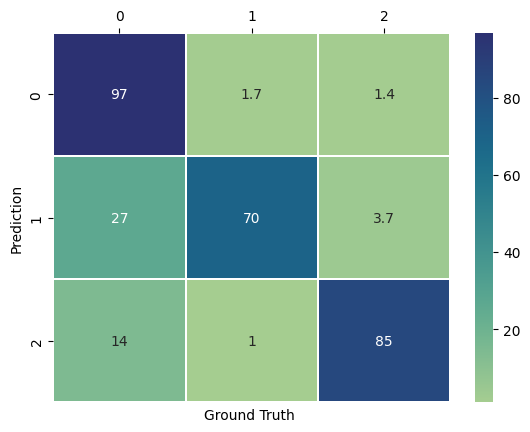

[[96.87201359  1.72627693  1.40170948]
 [26.65478558 69.62210928  3.72310514]
 [14.39619152  1.01035676 84.59345173]]


In [12]:
import seaborn
import matplotlib.pyplot as plt2
cm = confusion_matrix_(array_list_ground_truth,array_list_following_train)

ax = seaborn.heatmap(100*cm,annot=True, cmap="crest",linewidths=0.05)
ax.set(xlabel="Ground Truth ", ylabel="Prediction")
ax.xaxis.tick_top()
plt2.show()

print(100*cm)